In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"takonakie","key":"c83665a06a4668b2d914244f543cb6dc"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kmader/food41

Dataset URL: https://www.kaggle.com/datasets/kmader/food41
License(s): copyright-authors
100% 5.30G/5.30G [00:47<00:00, 90.1MB/s]
100% 5.30G/5.30G [00:47<00:00, 119MB/s] 


In [4]:
import zipfile
import os

# Unzip dataset
with zipfile.ZipFile("food41.zip", 'r') as zip_ref:
    zip_ref.extractall("food-101")

In [5]:
import os
import shutil

# Path to the extracted dataset
original_dataset_dir = "food-101/images"
subset_dir = "food-10"  # Output folder for the subset dataset

# Create the folder for the subset dataset if it doesn't exist
os.makedirs(subset_dir, exist_ok=True)

# Specify the 10 classes you want to use
selected_classes = [
    'baklava', 'beignets', 'chocolate_cake', 'churros', 'cup_cakes',
    'donuts', 'ice_cream', 'macarons', 'red_velvet_cake', 'waffles'
]

# Create a folder for each selected class
for class_name in selected_classes:
    class_dir = os.path.join(original_dataset_dir, class_name)
    target_class_dir = os.path.join(subset_dir, class_name)

    # Make sure the folder is valid (skip .ipynb_checkpoints or others)
    if not os.path.isdir(class_dir):
        continue  # Skip if the folder is not valid

    # Delete the target class folder if it already exists
    if os.path.isdir(target_class_dir):
        shutil.rmtree(target_class_dir)  # Remove existing target class folder

    # Create a new target folder for the class
    os.makedirs(target_class_dir, exist_ok=True)

    image_list = os.listdir(class_dir)

    for img_name in image_list:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(target_class_dir, img_name)
        shutil.copy(src, dst)

print("Subset dataset created successfully!")

Subset dataset created successfully!


#Sequential

## 1. Augmentation & Splitting

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the data directory
data_dir = 'food-10'

# Image size and batch size
img_size = (150, 150)
batch_size = 32

# ImageDataGenerator with augmentation and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,       # 20% for validation
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator for training data
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator for validation data (no need for augmentation)
val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Display number of classes and class names
print(f"Number of classes: {train_gen.num_classes}")
print(f"Class names: {train_gen.class_indices}")


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Number of classes: 10
Class names: {'baklava': 0, 'beignets': 1, 'chocolate_cake': 2, 'churros': 3, 'cup_cakes': 4, 'donuts': 5, 'ice_cream': 6, 'macarons': 7, 'red_velvet_cake': 8, 'waffles': 9}


## 2. Modeling & Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 1. Enhanced CNN model
model = Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # First Dense layer with more neurons
    Dropout(0.3),                    # Dropout to reduce overfitting
    Dense(128, activation='relu'),  # Second Dense layer with fewer neurons
    Dropout(0.4),                    # Another Dropout after the second Dense layer

    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# 2. Compile with a custom optimizer
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Add EarlyStopping and ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 4. Fit the model
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

# 5. Evaluation
loss, accuracy = model.evaluate(val_gen)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 284ms/step - accuracy: 0.1710 - loss: 3.4137 - val_accuracy: 0.1425 - val_loss: 3.2398 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 274ms/step - accuracy: 0.2447 - loss: 2.8598 - val_accuracy: 0.1940 - val_loss: 2.8886 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 281ms/step - accuracy: 0.2598 - loss: 2.7530 - val_accuracy: 0.2960 - val_loss: 2.5267 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.2838 - loss: 2.6502 - val_accuracy: 0.3450 - val_loss: 2.4036 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.3095 - loss: 2.5377 - val_accuracy: 0.3335 - val_loss: 2.4077 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 281ms/step - accuracy: 0.3268 - loss: 2.4846 - val_accuracy: 0.3525 - val_loss: 2.3717 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 28

## 3. Save the model

In [ ]:
model.save('sequential_30epoch_improve.h5')

## 4. Resume Training

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the previously saved model
model = load_model("sequential_30epoch_improve.h5")

# Recompile the model with a new learning rate
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Continue training for 30 more epochs
history_additional = model.fit(
    train_gen,
    epochs=30,  # Continue training for 30 more epochs
    validation_data=val_gen,
    callbacks=[reduce_lr]
)

# Evaluation
loss, accuracy = model.evaluate(val_gen)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 294ms/step - accuracy: 0.6075 - loss: 1.6049 - val_accuracy: 0.5950 - val_loss: 1.6489 - learning_rate: 5.0000e-05
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.6127 - loss: 1.5633 - val_accuracy: 0.6015 - val_loss: 1.6524 - learning_rate: 5.0000e-05
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.6006 - loss: 1.5808 - val_accuracy: 0.6040 - val_loss: 1.6290 - learning_rate: 5.0000e-05
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.6176 - loss: 1.5668 - val_accuracy: 0.6005 - val_loss: 1.6115 - learning_rate: 5.0000e-05
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 272ms/step - accuracy: 0.6249 - loss: 1.5432 - val_accuracy: 0.6070 - val_loss: 1.6229 - learning_rate: 5.0000e-05
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.6144 - loss: 1.5446 - val_accuracy: 0.6115 - val_loss: 1.6008 - learning_rate: 5.0000e-05
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 27

#ResNet50

## 1. Data Splitting

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Path to the dataset directory
data_dir = 'food-10'

# Image size and batch size
img_size = (224, 224)  # Must be 224 for ResNet50
batch_size = 32

# ImageDataGenerator with ResNet50 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator (still using preprocess_input, without extra augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Class information
print(f"Number of classes: {train_gen.num_classes}")
print(f"Class names: {train_gen.class_indices}")


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Number of classes: 10
Class names: {'baklava': 0, 'beignets': 1, 'chocolate_cake': 2, 'churros': 3, 'cup_cakes': 4, 'donuts': 5, 'ice_cream': 6, 'macarons': 7, 'red_velvet_cake': 8, 'waffles': 9}


## 2. Modeling & Evaluation

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the base ResNet50 (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# Add a custom head on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(10, activation='softmax')(x)  # Change 10 to match the number of classes

# Combine the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Initial training (only the head)
history_initial = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stop]
)

# ✅ Fine-tuning: unfreeze some of the last layers of ResNet
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze most layers
    layer.trainable = False

# Re-compile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train again (fine-tuning)
history_finetune = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stop]
)

# Final evaluation
loss, acc = model.evaluate(val_gen)
print(f"Final Accuracy: {acc:.4f}, Loss: {loss:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 487ms/step - accuracy: 0.3772 - loss: 1.9550 - val_accuracy: 0.7745 - val_loss: 0.7198 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 459ms/step - accuracy: 0.7165 - loss: 0.8936 - val_accuracy: 0.7825 - val_loss: 0.6730 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 119s 476ms/step - accuracy: 0.7650 - loss: 0.7497 - val_accuracy: 0.7930 - val_loss: 0.6199 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 458ms/step - accuracy: 0.7724 - loss: 0.6897 - val_accuracy: 0.8090 - val_loss: 0.5981 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 449ms/step - accuracy: 0.7969 - loss: 0.6305 - val_accuracy: 0.8185 - val_loss: 0.5667 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 460ms/step - accuracy: 0.8112 - loss: 0.5810 - val_accuracy: 0.8215 - val_loss: 0.5615 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

## 3. Save the model

In [ ]:
model.save('resnet50_optimal.h5')

## 4. Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step


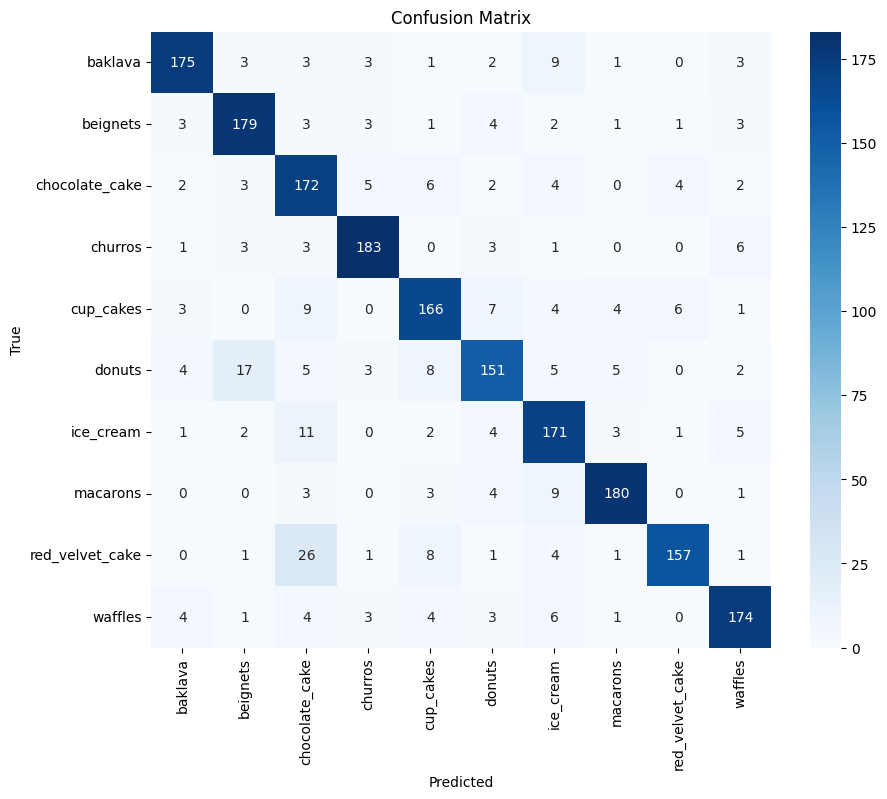

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation data
val_pred = model.predict(val_gen, batch_size=batch_size, verbose=1)

# Get the predicted class (index of the highest probability)
y_pred = np.argmax(val_pred, axis=1)

# Get the true labels from the generator
y_true = val_gen.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 5. Precision, Recall, & F1-Score

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Example confusion matrix (replace with your own matrix)
conf_matrix = np.array([
    [175, 3, 3, 3, 1, 2, 9, 1, 0, 3],
    [3, 179, 3, 3, 1, 4, 2, 1, 1, 3],
    [2, 3, 172, 5, 6, 2, 4, 0, 4, 2],
    [1, 3, 3, 183, 0, 3, 1, 0, 0, 6],
    [3, 0, 9, 0, 166, 7, 4, 4, 6, 1],
    [4, 17, 5, 3, 8, 151, 5, 5, 0, 2],
    [1, 2, 11, 0, 2, 4, 171, 3, 1, 5],
    [0, 0, 3, 0, 3, 4, 9, 180, 0, 1],
    [0, 1, 26, 1, 8, 1, 4, 1, 157, 1],
    [4, 1, 4, 3, 4, 3, 6, 1, 0, 174]
])

# Calculate TP, FP, FN per class
TP = np.diag(conf_matrix)  # True Positives: diagonal elements
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives: column sums minus TP
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives: row sums minus TP

# Avoid division by zero
precision = np.divide(TP, TP + FP, out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
recall = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)
f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(precision), where=(precision + recall) != 0)

# Print the results
labels = ['baklava', 'beignets', 'chocolate_cake', 'churros', 'cup_cakes',
          'donuts', 'ice_cream', 'macarons', 'red_velvet_cake', 'waffles']

for i, label in enumerate(labels):
    print(f"{label:<17} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1-score: {f1[i]:.3f}")


baklava           | Precision: 0.907 | Recall: 0.875 | F1-score: 0.891
beignets          | Precision: 0.856 | Recall: 0.895 | F1-score: 0.875
chocolate_cake    | Precision: 0.720 | Recall: 0.860 | F1-score: 0.784
churros           | Precision: 0.910 | Recall: 0.915 | F1-score: 0.913
cup_cakes         | Precision: 0.834 | Recall: 0.830 | F1-score: 0.832
donuts            | Precision: 0.834 | Recall: 0.755 | F1-score: 0.793
ice_cream         | Precision: 0.795 | Recall: 0.855 | F1-score: 0.824
macarons          | Precision: 0.918 | Recall: 0.900 | F1-score: 0.909
red_velvet_cake   | Precision: 0.929 | Recall: 0.785 | F1-score: 0.851
waffles           | Precision: 0.879 | Recall: 0.870 | F1-score: 0.874


#YOLO

## 1. Dataset conversion to YOLO format

In [8]:
import os
from PIL import Image
from pathlib import Path
import shutil
import random

# Source dataset path (classification style)
source_dir = 'food-10'  # change if your folder is different
target_dir = 'yolo_food-10'

# Prepare YOLO directory structure
image_train_dir = os.path.join(target_dir, 'images', 'train')
label_train_dir = os.path.join(target_dir, 'labels', 'train')
image_valid_dir = os.path.join(target_dir, 'images', 'valid')
label_valid_dir = os.path.join(target_dir, 'labels', 'valid')

os.makedirs(image_train_dir, exist_ok=True)
os.makedirs(label_train_dir, exist_ok=True)
os.makedirs(image_valid_dir, exist_ok=True)
os.makedirs(label_valid_dir, exist_ok=True)

# Map classes to numbers
classes = sorted(os.listdir(source_dir))  # e.g. ['fried_chicken', 'fried_rice']
class_to_id = {cls_name: i for i, cls_name in enumerate(classes)}

# Validation split percentage
valid_percentage = 0.2  # 20% for validation

# Process each image
for cls_name in classes:
    class_path = os.path.join(source_dir, cls_name)
    images = [img_file for img_file in os.listdir(class_path) if img_file.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Shuffle and split images into train and valid sets randomly
    random.shuffle(images)
    valid_size = int(len(images) * valid_percentage)
    valid_images = images[:valid_size]
    train_images = images[valid_size:]

    # Process training data
    for img_file in train_images:
        img_path = os.path.join(class_path, img_file)
        new_img_path = os.path.join(image_train_dir, img_file)
        new_txt_path = os.path.join(label_train_dir, Path(img_file).with_suffix('.txt'))

        # Copy image to images/train folder
        shutil.copy(img_path, new_img_path)

        # Create YOLO label: full bounding box
        label_id = class_to_id[cls_name]
        yolo_label = f"{label_id} 0.5 0.5 1.0 1.0\n"

        # Save label file
        with open(new_txt_path, 'w') as f:
            f.write(yolo_label)

    # Process validation data
    for img_file in valid_images:
        img_path = os.path.join(class_path, img_file)
        new_img_path = os.path.join(image_valid_dir, img_file)
        new_txt_path = os.path.join(label_valid_dir, Path(img_file).with_suffix('.txt'))

        # Copy image to images/valid folder
        shutil.copy(img_path, new_img_path)

        # Create YOLO label: full bounding box
        label_id = class_to_id[cls_name]
        yolo_label = f"{label_id} 0.5 0.5 1.0 1.0\n"

        # Save label file
        with open(new_txt_path, 'w') as f:
            f.write(yolo_label)

print("✅ Dataset successfully converted to YOLO format.")
print("📝 class_to_id mapping:", class_to_id)


✅ Dataset successfully converted to YOLO format.
📝 class_to_id mapping: {'baklava': 0, 'beignets': 1, 'chocolate_cake': 2, 'churros': 3, 'cup_cakes': 4, 'donuts': 5, 'ice_cream': 6, 'macarons': 7, 'red_velvet_cake': 8, 'waffles': 9}


## 2. Splitting the data

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Specify the source data folder (for example, the train folder)
data_folder = '/content/yolo_food-10/images/train'

# Get all image files in the folder
image_files = [f for f in os.listdir(data_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Split data into 80% training and 20% validation
train_files, valid_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Specify the target folder for validation images
valid_folder = '/content/yolo_food-10/images/valid'

# Create the validation folder if it doesn't exist
os.makedirs(valid_folder, exist_ok=True)

# Move images and their label files from train to valid
for img in valid_files:
    # Create the corresponding label filename before moving the image
    label_file = img.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')

    # Move both image and label if the label file exists
    if os.path.exists(os.path.join(data_folder, label_file)):
        shutil.move(os.path.join(data_folder, img), os.path.join(valid_folder, img))
        shutil.move(os.path.join(data_folder, label_file), os.path.join(valid_folder, label_file))

# Update image lists in train and valid folders after moving files
train_files = [f for f in os.listdir(data_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
valid_files = [f for f in os.listdir(valid_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

print(f"Training data: {len(train_files)} images")
print(f"Validation data: {len(valid_files)} images")


Training data: 8000 images
Validation data: 2000 images


## 3. Create .yaml file

In [ ]:
yaml_content = """
path: /content/yolo_food-10
train: images/train
val: images/valid
nc: 10
names:
  0: baklava
  1: beignets
  2: chocolate_cake
  3: churros
  4: cup_cakes
  5: donuts
  6: ice_cream
  7: macarons
  8: red_velvet_cake
  9: waffles
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)


## 4. Install Ultralytics

In [ ]:
!pip install ultralytics

  Using cached ultralytics-8.3.127-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.

## 5. Modeling

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model weights (you can replace with yolov8s.pt, yolov8m.pt, yolov8l.pt, or yolov8x.pt)
model = YOLO("yolov8n.pt")

# Train the model using your dataset config (data.yaml), for 30 epochs, image size 640x640, batch size 16
model.train(data="data.yaml", epochs=30, imgsz=640, batch=16)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 326MB/s]


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

100%|██████████| 755k/755k [00:00<00:00, 128MB/s]

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

 22        [15, 18, 21]  1    753262  ultralytics.nn.modules.head.Detect           [10, [64, 128, 256]]          
Model summary: 129 layers, 3,012,798 parameters, 3,012,782 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.8±6.4 MB/s, size: 45.1 KB)


train: Scanning /content/yolo_food-10/labels/train... 1984 images, 0 backgrounds, 0 corrupt:  25%|██▍       | 1984/8000 [00:04<00:13, 461.20it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
train: Scanning /content/yolo_food-10/labels/train... 8000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8000/8000 [00:13<00:00, 585.43it/s]


train: New cache created: /content/yolo_food-10/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.1±4.3 MB/s, size: 35.8 KB)


val: Scanning /content/yolo_food-10/labels/valid... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:03<00:00, 584.64it/s]

val: New cache created: /content/yolo_food-10/labels/valid.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.04G     0.2051      2.309     0.9899         59        640: 100%|██████████| 500/500 [02:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


                   all       2000       2000      0.559      0.634      0.649      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.58G     0.1299      1.435     0.9209         49        640: 100%|██████████| 500/500 [02:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


                   all       2000       2000      0.711       0.66      0.751      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.58G     0.1282      1.281     0.9141         52        640: 100%|██████████| 500/500 [02:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]

                   all       2000       2000      0.718      0.672      0.776      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.6G     0.1155      1.175     0.9062         52        640: 100%|██████████| 500/500 [02:12<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]


                   all       2000       2000      0.787      0.694      0.811      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.61G     0.1054      1.087      0.902         54        640: 100%|██████████| 500/500 [02:11<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]

                   all       2000       2000      0.765      0.745      0.846       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.63G    0.09393      1.043     0.8986         55        640: 100%|██████████| 500/500 [02:12<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

                   all       2000       2000       0.77      0.736      0.849      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.65G    0.08708     0.9756     0.8955         50        640: 100%|██████████| 500/500 [02:12<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]

                   all       2000       2000      0.801      0.781      0.875      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.66G    0.08344     0.9452     0.8925         52        640: 100%|██████████| 500/500 [02:12<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]

                   all       2000       2000      0.834      0.769      0.888      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.68G    0.07846     0.9131     0.8944         50        640: 100%|██████████| 500/500 [02:11<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]

                   all       2000       2000      0.861      0.769      0.892      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       2.7G    0.07415     0.8688     0.8892         51        640: 100%|██████████| 500/500 [02:11<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]

                   all       2000       2000      0.839      0.813      0.904        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.71G    0.07061     0.8648     0.8904         51        640: 100%|██████████| 500/500 [02:11<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]

                   all       2000       2000      0.863      0.794      0.898       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.73G    0.06686     0.8402      0.888         53        640: 100%|██████████| 500/500 [02:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]

                   all       2000       2000      0.829      0.807      0.903      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.75G     0.0668     0.8162     0.8883         47        640: 100%|██████████| 500/500 [02:11<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]

                   all       2000       2000      0.866      0.807      0.917      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.77G     0.0634     0.7841     0.8875         45        640: 100%|██████████| 500/500 [02:10<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  3.94it/s]

                   all       2000       2000      0.876      0.806      0.913      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.78G    0.06033     0.7679     0.8881         51        640: 100%|██████████| 500/500 [02:10<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]

                   all       2000       2000      0.876      0.826      0.917      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       2.8G    0.05958      0.759     0.8866         47        640: 100%|██████████| 500/500 [02:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]

                   all       2000       2000      0.876      0.821      0.921      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.82G    0.05673     0.7368     0.8873         53        640: 100%|██████████| 500/500 [02:10<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]

                   all       2000       2000      0.836      0.845      0.927       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.83G    0.05353     0.7169     0.8812         47        640: 100%|██████████| 500/500 [02:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]

                   all       2000       2000       0.89      0.864      0.939      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.85G    0.05124     0.7006     0.8827         50        640: 100%|██████████| 500/500 [02:13<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]

                   all       2000       2000      0.893      0.844      0.934       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.87G    0.04975     0.6895     0.8808         45        640: 100%|██████████| 500/500 [02:11<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]

                   all       2000       2000      0.889      0.864      0.937      0.931


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.89G    0.05254     0.4206     0.8948         16        640: 100%|██████████| 500/500 [02:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]

                   all       2000       2000        0.9      0.837      0.937      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       2.9G    0.04251     0.3682     0.8826         16        640: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]

                   all       2000       2000      0.921      0.841      0.938      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.92G    0.03788     0.3298     0.8771         16        640: 100%|██████████| 500/500 [02:06<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]

                   all       2000       2000      0.889      0.867       0.94       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.94G    0.03541      0.294       0.88         16        640: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]

                   all       2000       2000      0.908      0.874      0.945      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.96G    0.03436     0.2818     0.8813         16        640: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]

                   all       2000       2000      0.902      0.869      0.949      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.97G    0.03092     0.2617     0.8799         16        640: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]

                   all       2000       2000      0.922      0.858      0.946      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.99G    0.02918     0.2361     0.8818         16        640: 100%|██████████| 500/500 [02:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]

                   all       2000       2000      0.905      0.874      0.945      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.01G    0.02811      0.215     0.8822         16        640: 100%|██████████| 500/500 [02:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]

                   all       2000       2000      0.926      0.856      0.948      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.02G    0.02648     0.1976     0.8784         16        640: 100%|██████████| 500/500 [02:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]

                   all       2000       2000      0.899      0.879      0.947      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.04G    0.02478     0.1801     0.8763         16        640: 100%|██████████| 500/500 [02:04<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]


                   all       2000       2000      0.912      0.875       0.95       0.95

30 epochs completed in 1.223 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]


                   all       2000       2000      0.911      0.875       0.95       0.95
               baklava        200        200      0.943       0.96      0.985      0.985
              beignets        200        200      0.877      0.856      0.954      0.954
        chocolate_cake        200        200      0.857      0.867      0.915      0.915
               churros        200        200      0.939      0.865      0.959      0.959
             cup_cakes        200        200      0.945       0.86      0.956      0.956
                donuts        200        200      0.861       0.81      0.914      0.914
             ice_cream        200        200       0.87       0.82      0.921      0.921
              macarons        200        200       0.94      0.936      0.967      0.967
       red_velvet_cake        200        200      0.946      0.845      0.956      0.956
               waffles        200        200      0.936       0.93      0.972      0.972
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bab60a9b290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

## 6. Save the model

In [ ]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')
files.download('/content/runs/detect/train/weights/last.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Confusion Matrix

Labels: 2000 | Preds: 2000


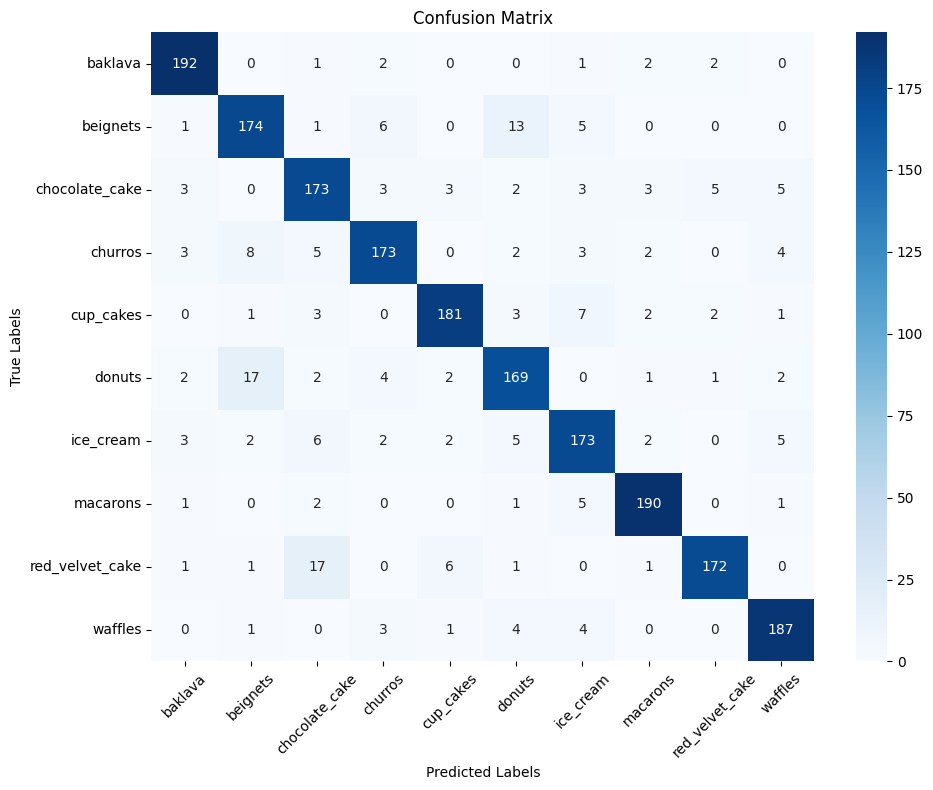

In [ ]:
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load model
model = YOLO("runs/detect/train/weights/best.pt")

# Path to validation images and labels
val_images_path = "/content/yolo_food-10/images/valid"
val_labels_path = "/content/yolo_food-10/labels/valid"

# Get list of image files
image_files = [f for f in os.listdir(val_images_path) if f.endswith(".jpg")]

all_labels = []
all_preds = []

for image_file in image_files:
    # Predict on image
    results = model(os.path.join(val_images_path, image_file), verbose=False)

    # Take the highest confidence prediction (if any)
    result = results[0]
    if result.boxes:
        top_idx = result.boxes.conf.argmax()
        top_class = int(result.boxes.cls[top_idx].cpu().numpy())
        all_preds.append(top_class)
    else:
        all_preds.append(-1)  # Not detected

    # Get the true label from the .txt file
    label_file = image_file.replace(".jpg", ".txt")
    with open(os.path.join(val_labels_path, label_file), "r") as f:
        label_line = f.readline()
        if label_line:
            true_class = int(label_line.strip().split()[0])
        else:
            true_class = -1  # No label

    all_labels.append(true_class)

# Verify lengths match
print("Labels:", len(all_labels), "| Predictions:", len(all_preds))

# Class names (ordered by ID)
class_names = [
    "baklava", "beignets", "chocolate_cake", "churros", "cup_cakes",
    "donuts", "ice_cream", "macarons", "red_velvet_cake", "waffles"
]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Testing


0: 640x640 1 beignets, 19.8ms
Speed: 4.0ms preprocess, 19.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


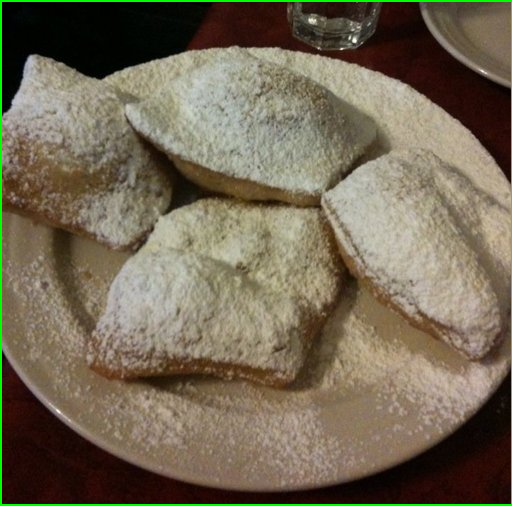

In [ ]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load YOLO model
model = YOLO('runs/detect/train/weights/best.pt')  # Replace with your model path

# Load image
image_path = '/content/yolo_food-10/images/valid/1002850.jpg'  # Replace with the image path you want to detect
img = cv2.imread(image_path)

# Perform object detection
results = model(img)

# Access detection results
for result in results:  # Loop for each detection result (sometimes can be more than one image)
    boxes = result.boxes  # Access bounding boxes
    scores = boxes.conf  # Access confidence scores (inside 'boxes')
    classes = boxes.cls  # Access detected classes

    # Display detection results on the image
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get bounding box coordinates and convert to list
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])  # Convert coordinates to integers
        class_id = int(classes[i].item())  # Class ID
        confidence = scores[i].item()  # Confidence score

        # Draw bounding box and label on the image
        label = f"{model.names[class_id]}: {confidence:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green box
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with detections
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()